# Initiation

In [2]:
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# For working with x-arrays
import xarray as xr

# Import trackArrayTools
cwd = os.getcwd()
os.chdir("../src")
from track_array_tools import *
os.chdir(cwd)

# # Just in case you want to edit the track_array_tools.py code and test it, use the following
# cwd = os.getcwd()
# os.chdir("../src")
# del sys.modules['track_array_tools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
# from track_array_tools import *
# os.chdir(cwd)

# Read in video and csv tracking file to generate crop array video

In [3]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'
csv_filename = r'Tracks_Hela_confocal.csv'
#  crop array filenames should be the following:
crop_array_filename = 'Crops_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
crop_filename = crop_array_filename[:-15] + '.csv'
# For display, so z and xy are shown properly when viewing crop array
z_renorm = z_pixel_size/xy_pixel_size  

In [4]:
# Read in the 3D video 
video_3D = imread(os.path.join(video_3D_directory,video_3D_filename))
video_3D.shape

(33, 7, 472, 312, 3)

In [5]:
# Read in the tracking file that corresponds to the original 3D video
# csv file can have many columns, but must have POSITION_X, POSITION_Y,
tracks = pd.read_csv(os.path.join(video_3D_directory, crop_filename)) 
tracks

,Label,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,MANUAL_COLOR,MEAN_INTENSITY,MEDIAN_INTENSITY,MIN_INTENSITY,MAX_INTENSITY,TOTAL_INTENSITY,STANDARD_DEVIATION,ESTIMATED_DIAMETER,CONTRAST,SNR
0,ID10777,10777,0,458.712,69.0,14.0,0.0,0,0,3.5,...,-10921639,1097.358,1080,564,2118,374199,199.929,13.300,0.069,0.708
1,ID11306,11306,0,567.212,69.0,13.0,0.0,1,1,3.5,...,-10921639,1135.689,1119,722,2142,387270,200.616,11.816,0.086,0.896
2,ID11135,11135,0,552.813,69.0,14.0,0.0,2,2,3.5,...,-10921639,1129.935,1106,671,2660,385308,213.099,10.408,0.080,0.788
3,ID10954,10954,0,583.929,69.0,14.0,0.0,3,3,3.5,...,-10921639,1129.091,1115,627,2281,385020,222.905,12.483,0.083,0.773
4,ID11466,11466,0,504.716,70.0,13.0,0.0,4,4,3.5,...,-10921639,1120.109,1100,624,2455,381957,203.120,12.474,0.084,0.853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,ID15447,15447,315,342.325,30.0,28.0,0.0,28,28,3.5,...,-10921639,1155.088,1131,679,2247,393885,207.499,10.435,0.074,0.770
2977,ID15282,15282,315,253.879,34.0,28.0,0.0,29,29,3.5,...,-10921639,1129.437,1108,660,2006,385138,173.531,12.342,0.066,0.811
2978,ID15609,15609,315,345.149,35.0,27.0,0.0,30,30,3.5,...,-10921639,1150.065,1135,683,2082,392172,196.783,11.993,0.075,0.814
2979,ID15774,15774,315,300.118,35.0,27.0,0.0,31,31,3.5,...,-10921639,1127.909,1108,595,2036,384617,188.746,10.607,0.067,0.754


In [6]:
# Create crop array tif video from the original 3D video
# This only needs to be done once. Thereafter, can skip and just work with crop array itself
# Video dimensiosn MUST BE T, Z, Y, X, C or, if single channel video, then MUST BE T, Z, Y, X  
create_track_array_video(video_3D_directory, crop_array_filename, video_3D, tracks, crop_pad, xy_pixel_size, z_pixel_size)

c:\Users\tim_s\OneDrive - Colostate\Stasevich Lab\Lab Management\Dry Lab\Python\croparray\src\track_array_tools.py:864: UserWarning: ../database\Crops_Hela_confocal_crop_pad_5.tif is a low contrast image
  metadata={'spacing':z_pixel_size,'unit':'nm'})  # store z spaxing in nm and set units to nm


# Create an X-array dataset using the CropArray class

In [7]:
# Read in the crop array video and crop array dataframe:
crop_array_vid = imread(os.path.join(video_3D_directory, crop_array_filename))  # Read in crop array .tif file
#Read in crop_array and convert to standard dimensions for X-array
crop_array_df = pd.read_csv(os.path.join(video_3D_directory, crop_filename)).rename(columns={'FRAME':'frame','TRACK_ID':'crop_number','ID':'crop_id','POSITION_X':'crop_x','POSITION_Y':'crop_y'}) # standard crop array dimensions# 

In [8]:
# Create a crop array object:
ca = CropArray(crop_array_vid, crop_array_df, crop_pad)

In [9]:
# Create a best-z projection, bext_z, and also a best_z projection that is background corrected, best_z_bg
my_best_z_masks = ca.best_z_mask(1,0,z_offset = [0,0,0]) # best-z mask w/0 z-offset between channels
best_z = ca.mask_projection(np.clip(ca.arr,0,1000000), my_best_z_masks) # best-z projection; clip to make sure data is +
best_z_bg = ca.local_background_subtract(best_z,ca.donut_mask_2D(5,1)) # subtract background in donut rings from max projection  

In [12]:
# Create an X-array object from the crop array:
crop_number =np.arange(ca.n_crops())
frame =np.arange(ca.n_frames())
z=np.arange(ca.z_slices())
y=np.arange(-ca.crop_pad,ca.crop_pad+1)
x=np.arange(-ca.crop_pad,ca.crop_pad+1)
ch=np.arange(ca.n_channels())
fov=np.arange(1)
dx = xr.DataArray(130, coords=[fov],dims=['fov'],attrs={'units':'nm'}) # can set attributes here to get unit measure
dy = xr.DataArray(130, coords=[fov],dims=['fov'],attrs={'units':'nm'}) # can set attributes here to get unit measure
dz = xr.DataArray(500, coords=[fov],dims=['fov'],attrs={'units':'nm'}) # can set attributes here to get unit measure
dt = xr.DataArray(1, coords=[fov],dims=['fov'],attrs={'units':'sec'}) # can set attributes here to get unit measure
int = xr.DataArray(np.array([ca.crops()]), coords=[fov,crop_number,frame,z,y,x,ch], dims=["fov","crop_number","frame","z","y","x","ch"])
best_z_int = xr.DataArray(np.array([ca.array_to_crops(best_z)]),coords=[fov,crop_number,frame,y,x,ch],dims=["fov","crop_number","frame","y","x","ch"])
best_z_bg_int = xr.DataArray(np.array([ca.array_to_crops(best_z_bg)]),coords=[fov,crop_number,frame,y,x,ch],dims=["fov","crop_number","frame","y","x","ch"])

In [19]:
dx.attrs['units']

'nm'

In [11]:
# Create an X-array dataset
my_ds = xr.Dataset({
'intensity':int,
'intensity_best_z':best_z_int,
'intensity_best_z_bg':best_z_bg_int,
'x_dim': x_dim
}, 
attrs = {'example attrs':'This is a global attribute'}
)
my_columns=list(crop_array_df.columns)
my_columns.remove('crop_number')
my_columns.remove('frame')
for col in my_columns:
    my_ds[col]=xr.DataArray(crop_array_df.pivot(index='crop_number',columns='frame')[col])
my_ds

<xarray.Dataset>
Dimensions:              (crop_number: 110, fov: 1, frame: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * crop_number          (crop_number) int32 0 1 2 3 4 5 ... 105 106 107 108 109
  * fov                  (fov) int32 0
  * frame                (frame) int64 0 1 2 3 4 5 6 7 ... 26 27 28 29 30 31 32
  * z                    (z) int32 0 1 2 3 4 5 6
  * y                    (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x                    (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch                   (ch) int32 0 1 2
Data variables: (12/23)
    intensity            (fov, crop_number, frame, z, y, x, ch) float64 23.0 ...
    intensity_best_z     (fov, crop_number, frame, y, x, ch) float64 23.0 ......
    intensity_best_z_bg  (fov, crop_number, frame, y, x, ch) float64 -2.775 ....
    x_dim                (fov) int32 130
    Label                (crop_number, frame) object 'ID10777' ... 'ID16079'
    crop_id              (crop_number, frame) float64 1.078e+04 ... 1.608e+04
    ...                   ...
    MAX_INTENSITY        (crop_number, frame) float64 2.118e+03 ... 2.287e+03
    TOTAL_INTENSITY      (crop_number, frame) float64 3.742e+05 ... 4.874e+05
    STANDARD_DEVIATION   (crop_number, frame) float64 199.9 200.6 ... 228.5
    ESTIMATED_DIAMETER   (crop_number, frame) float64 13.3 11.82 ... 11.81 11.77
    CONTRAST             (crop_number, frame) float64 0.069 0.086 ... 0.077
    SNR                  (crop_number, frame) float64 0.708 0.896 ... 0.898
Attributes:
    example attrs:  This is a global attribute

# Disk-donut quantification

In [17]:
disk = my_ds.intensity_best_z.where(lambda x: x.x**2 + x.y**2 <= 3**2).mean(dim=['x','y'])
donut = my_ds.intensity_best_z.where(lambda x: (x.x**2 + x.y**2 >= 5**2) & (x.x**2 + x.y**2 < 6**2)).mean(dim=['x','y'])
my_signal = disk - donut
my_ds['crop_signal'] = my_signal

In [18]:
my_ds

<xarray.Dataset>
Dimensions:              (crop_number: 110, fov: 1, frame: 33, z: 7, y: 11, x: 11, ch: 3)
Coordinates:
  * crop_number          (crop_number) int32 0 1 2 3 4 5 ... 105 106 107 108 109
  * fov                  (fov) int32 0
  * frame                (frame) int64 0 1 2 3 4 5 6 7 ... 26 27 28 29 30 31 32
  * z                    (z) int32 0 1 2 3 4 5 6
  * y                    (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x                    (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch                   (ch) int32 0 1 2
Data variables: (12/24)
    intensity            (fov, crop_number, frame, z, y, x, ch) float64 23.0 ...
    intensity_best_z     (fov, crop_number, frame, y, x, ch) float64 23.0 ......
    intensity_best_z_bg  (fov, crop_number, frame, y, x, ch) float64 -2.775 ....
    x_dim                (fov) int32 130
    Label                (crop_number, frame) object 'ID10777' ... 'ID16079'
    crop_id              (crop_number, frame) float64 1.078e+04 ... 1.608e+04
    ...                   ...
    TOTAL_INTENSITY      (crop_number, frame) float64 3.742e+05 ... 4.874e+05
    STANDARD_DEVIATION   (crop_number, frame) float64 199.9 200.6 ... 228.5
    ESTIMATED_DIAMETER   (crop_number, frame) float64 13.3 11.82 ... 11.81 11.77
    CONTRAST             (crop_number, frame) float64 0.069 0.086 ... 0.077
    SNR                  (crop_number, frame) float64 0.708 0.896 ... 0.898
    crop_signal          (fov, crop_number, frame, ch) float64 10.78 ... 0.0
Attributes:
    example attrs:  This is a global attribute

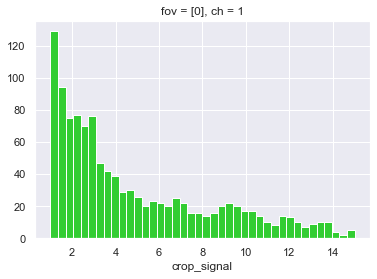

In [19]:
sns.set_palette(['limegreen','blue'])
my_ds.crop_signal.sel(ch=1).rolling(frame=5,center=True).mean().plot.hist(bins=40,range=(1,15));

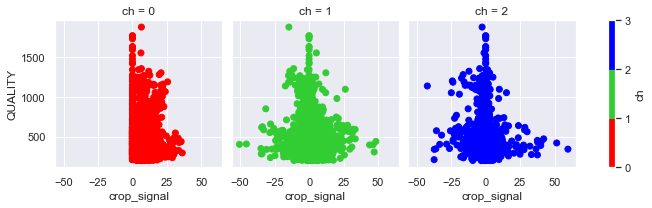

In [20]:
my_ds.plot.scatter(x='crop_signal',y='QUALITY',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

# Finding crops where translation is occuring

In [24]:
ds_trans=my_ds.where(my_ds.crop_signal.sel(ch=1,fov=0).rolling(frame=5,center=True).mean()>5,drop=True).intensity_best_z_bg

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


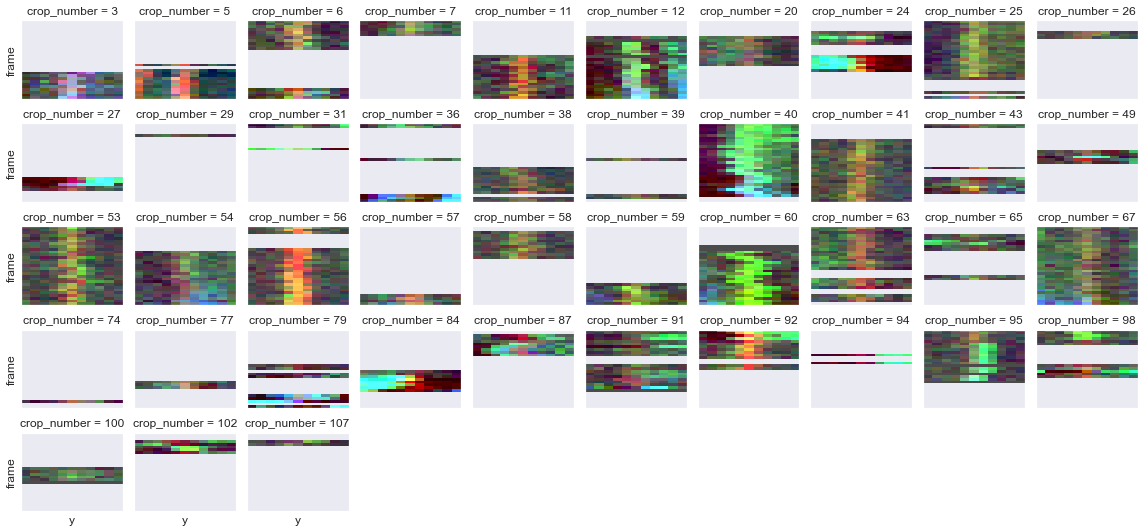

In [26]:
ds_trans.sel(fov=0).mean('x').plot.imshow(col='crop_number',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


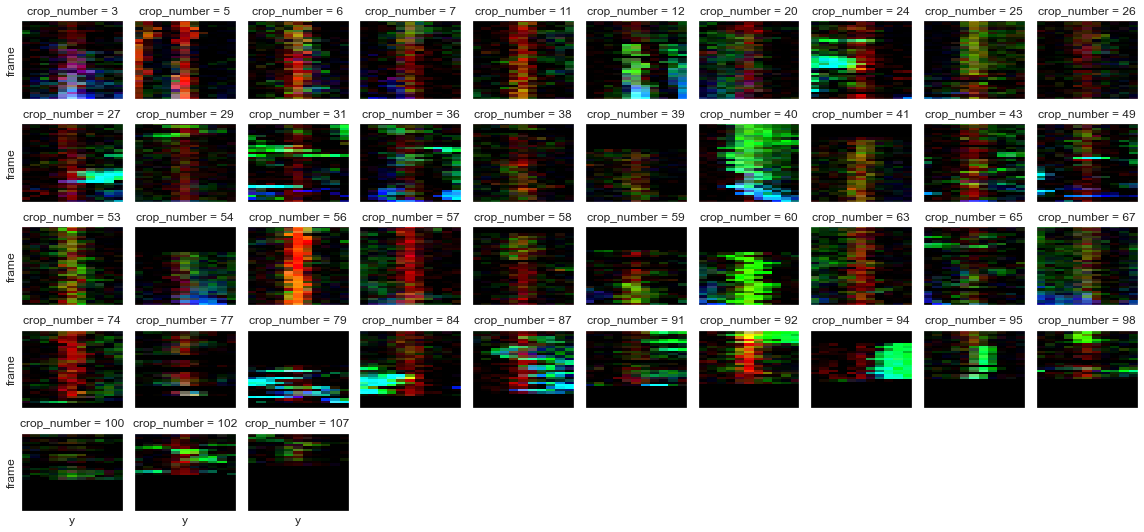

In [27]:
my_ds.sel(fov=0).intensity_best_z_bg.sel(crop_number=ds_trans.crop_number).mean('x').plot.imshow(col='crop_number',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,vmin=0,vmax=30)

# Sorting crops by translation signal intensity

In [36]:
ds_sort=my_ds.intensity_best_z_bg.sortby(my_ds.crop_signal.mean('frame').sel(ch=1,fov=0),ascending=False)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


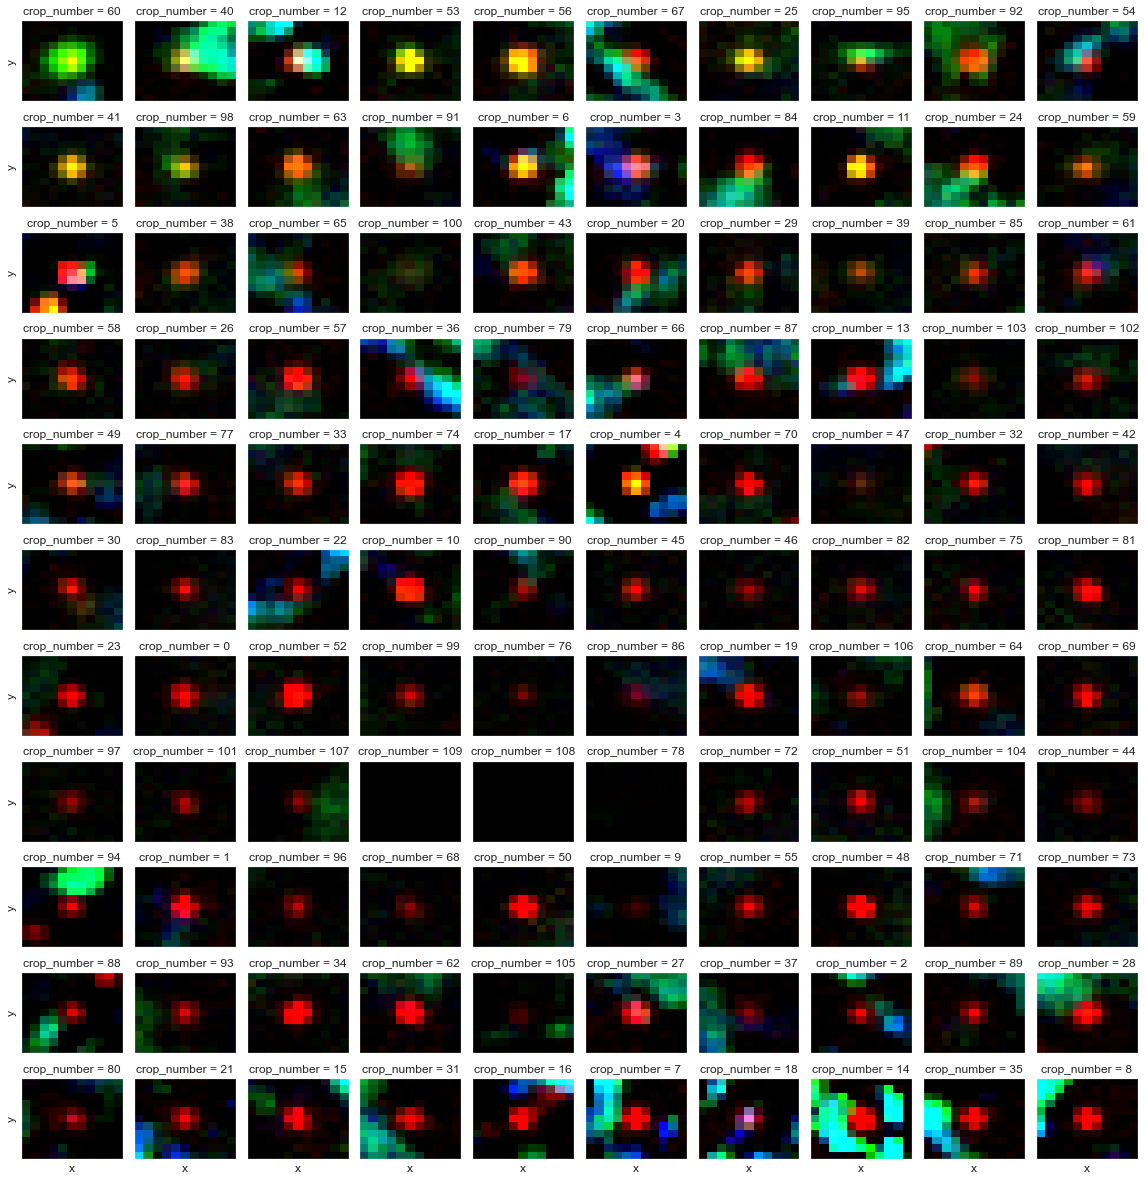

In [32]:
ds_sort.sel(fov=0).mean('frame').plot.imshow(col='crop_number',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,vmin=0,vmax=30)

# Napari and napari-like arrays

In [38]:
my_img = np.nan_to_num(ca.crops_to_array(ds_sort.sel(fov=0)))
napari_viewer(my_img,spatial_scale=[1,1])

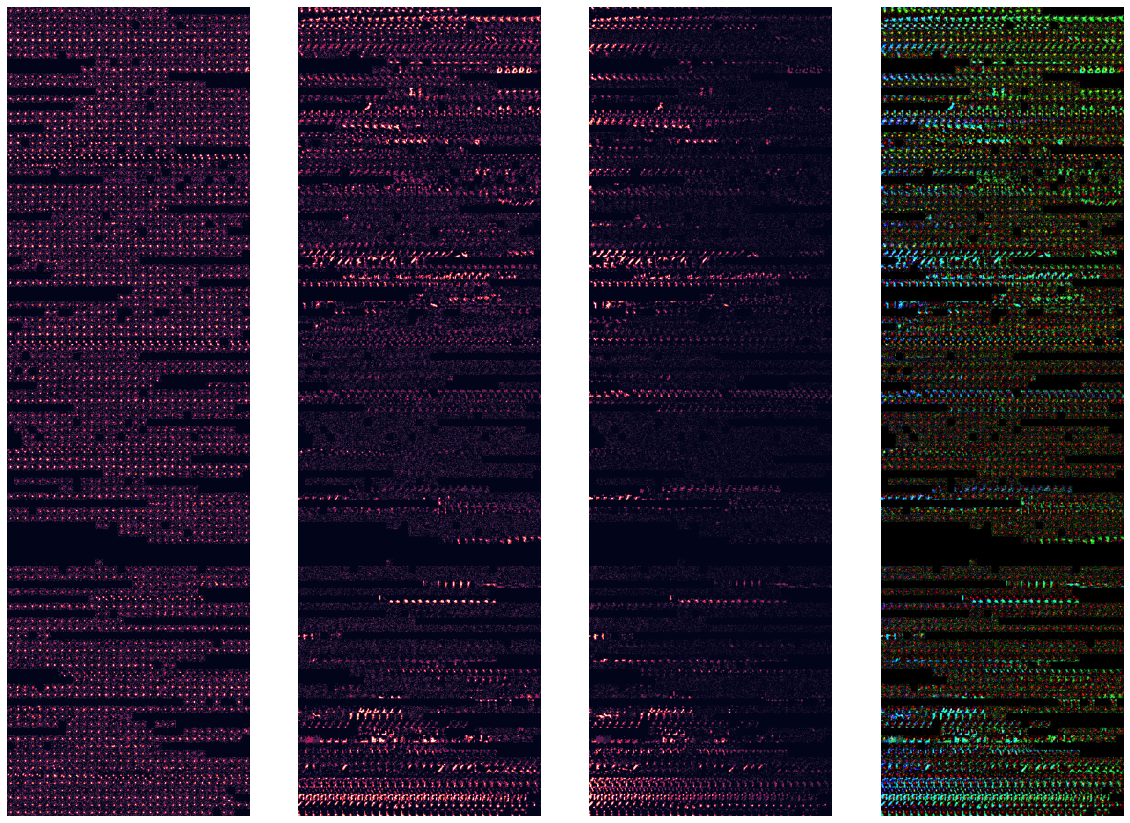

In [39]:
fig, ax = plt.subplots(1,4, figsize=(20, 20))
ax[0].imshow(np.clip(my_img[:,:,0],0,30))
ax[0].set_axis_off()
ax[1].imshow(np.clip(my_img[:,:,1],0,50))
ax[1].set_axis_off()
ax[2].imshow(np.clip(my_img[:,:,2],0,60))
ax[2].set_axis_off()
ax[3].imshow(np.clip(my_img[:,:,:]/30,0,1))
ax[3].set_axis_off()

# Other plotting examples

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


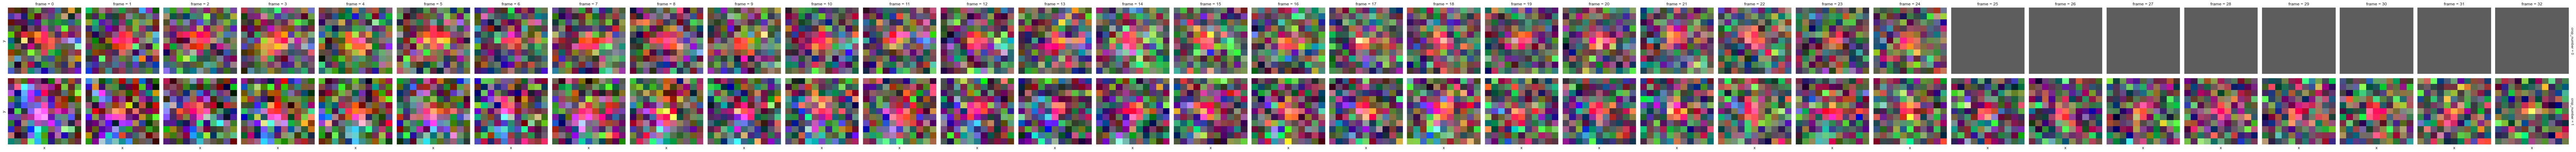

In [40]:
my_ds.intensity_best_z_bg.sel(fov=0,frame=slice(0,33),crop_number=slice(0,1)).plot.imshow(col='frame',row='crop_number',rgb='ch',yticks=[],xticks=[],robust=True)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


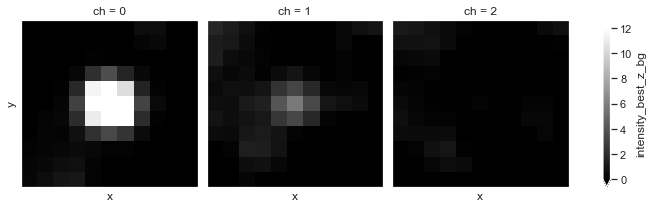

In [41]:
my_ds.intensity_best_z_bg.mean(['crop_number','frame','fov']).plot.imshow(col='ch',yticks=[],xticks=[],cmap='gray',vmin=0,vmax=12)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


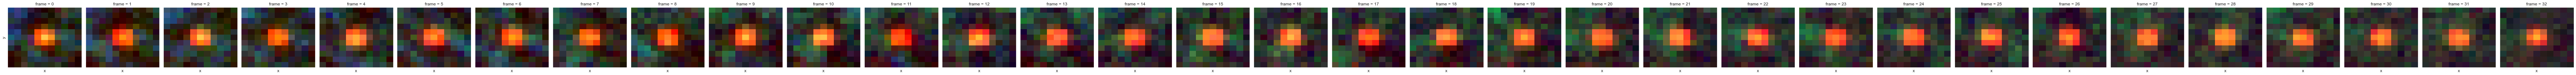

In [45]:
my_ds.intensity_best_z_bg.groupby('frame').mean(['fov','crop_number']).plot.imshow(col='frame',rgb='ch',yticks=[],xticks=[],robust=True)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


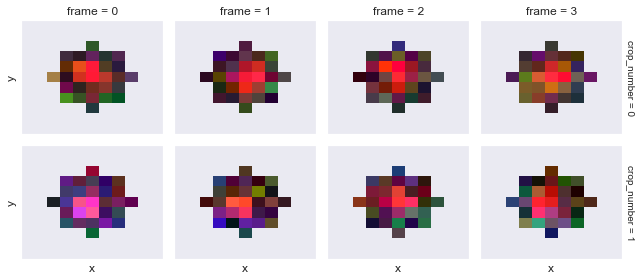

In [46]:
my_ds.intensity_best_z_bg.where(lambda x: x.x**2 + x.y**2 <= 3**2).sel(fov=0,frame=slice(0,3),crop_number=slice(0,1)).plot.imshow(col='frame',row='crop_number',rgb='ch',yticks=[],xticks=[],robust=True,size=2)

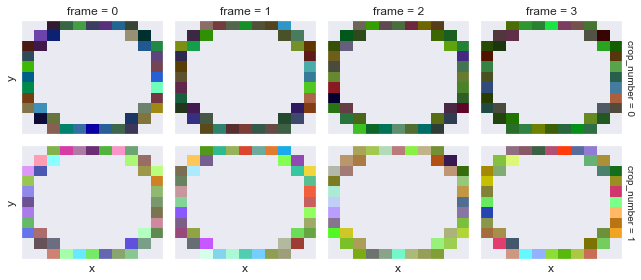

In [15]:
my_ds.intensity_best_z.where(lambda x: (x.x**2 + x.y**2 >= 5**2) & (x.x**2 + x.y**2 < 6**2)).sel(fov=0,frame=slice(0,3),crop_number=slice(0,1)).plot.imshow(col='frame',row='crop_number',rgb='ch',yticks=[],xticks=[],robust=True,size=2)

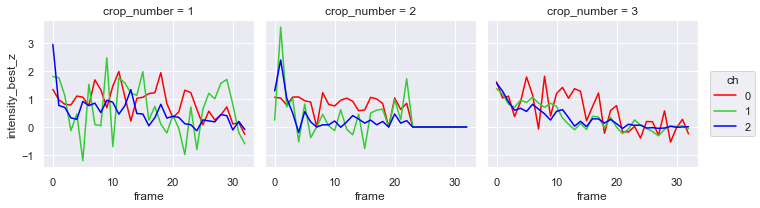

In [47]:
my_signal_norm = ( my_signal-my_signal.sel(fov=0,frame=slice(30,33)).mean('frame') )/( my_signal.sel(fov=0,frame=slice(0,4)).mean('frame')-my_signal.sel(frame=slice(30,33)).mean('frame') )
sns.set_palette(['red','limegreen','blue'])
g=my_signal_norm.sel(crop_number=slice(1,3)).plot(col='crop_number',hue='ch')


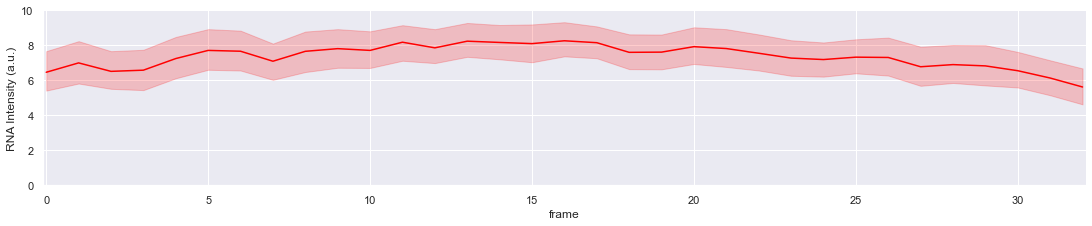

In [48]:
sns.set_style('darkgrid')
my_data = my_ds.crop_signal.sel(fov=0,ch=0).to_pandas()
g=sns.relplot(x='frame', y='RNA Intensity (a.u.)',data=pd.melt(my_data,value_name="RNA Intensity (a.u.)"),kind='line',height=3,aspect=5)
g.set(ylim=(0, 10))
g.set(xlim=(-.1,32.1))
plt.savefig('test.svg', format = 'svg', dpi=300)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


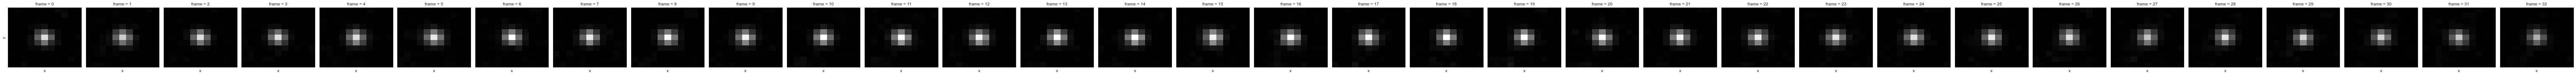

In [49]:
my_ds.intensity_best_z_bg.groupby('frame').mean(['fov','crop_number']).sel(ch=0).plot.imshow(col='frame',yticks=[],xticks=[],cmap='gray',add_colorbar=False, vmin=0,vmax=50)

In [50]:
donut_sanity_check = my_ds.intensity_best_z_bg.where(lambda x: (x.x**2 + x.y**2 >= 5**2) & (x.x**2 + x.y**2 < 6**2)).mean(['x','y'])

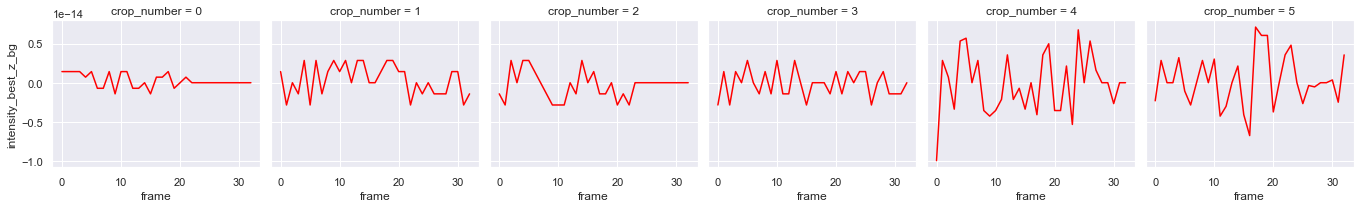

In [51]:
donut_sanity_check.sel(fov=0,ch=0,crop_number=slice(0,5)).plot(col='crop_number',hue='ch',col_wrap=6)